<a href="https://colab.research.google.com/github/9oelM/ml/blob/main/Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An object-oriented perceptron API

Let's go ahead and implements Rosenblatt's perceptron rule in Python.
We are going to build an object-oriented perceptron API and try the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) on it.

## Iris dataset
Let us load the two flower classes Setosa and Versicolor from the Iris dataset. Although the perceptron rule is not restricted to two dimensions, we will only consider the two features: **sepal length and petal length** for visualization purposes. Also, we only chose the two flower classes Setosa and Versicolor for practical reasons. However, the perceptron algorithm can be extended to multi-class classification—for example, the One-versus-All (OvA) technique.

First, we will use the pandas library to load the Iris dataset directly from the UCI Machine Learning Repository into a DataFrame object and print the last five lines via the `tail` method to check the data was loaded correctly.


In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
# df.head()
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


Next, we extract the first 100 class labels that correspond to the 50 Iris-setosa and 50 Iris-versicolor flowers, and convert the class labels into the two integer class labels `1` (versicolor) and `-1` (setosa) that we assign to a vector `y`, where the values method of a pandas DataFrame yields the corresponding NumPy representation.

Similarly, we extract the **first feature column (sepal length) and the third feature column (petal length) of those 100 training samples** and assign them to a feature matrix `X`.

In [8]:
import numpy as np
y = df.iloc[0:100, 4]
print(y) # extract the 4th column from the dataframe
y = np.where(y == 'Iris-setosa', -1, 1)
print(y) # -1 is setosa, 1 is versicolor
X = df.iloc[0:100, [0, 2]].values
print(X[-20:]) # the last 20 features (consisting of first and third features)

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
           ...       
95    Iris-versicolor
96    Iris-versicolor
97    Iris-versicolor
98    Iris-versicolor
99    Iris-versicolor
Name: 4, Length: 100, dtype: object
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1]
[[5.5 3.8]
 [5.5 3.7]
 [5.8 3.9]
 [6.  5.1]
 [5.4 4.5]
 [6.  4.5]
 [6.7 4.7]
 [6.3 4.4]
 [5.6 4.1]
 [5.5 4. ]
 [5.5 4.4]
 [6.1 4.6]
 [5.8 4. ]
 [5.  3.3]
 [5.6 4.2]
 [5.7 4.2]
 [5.7 4.2]
 [6.2 4.3]
 [5.1 3. ]
 [5.7 4.1]]


We can visualize via a two-dimensional scatter plot.

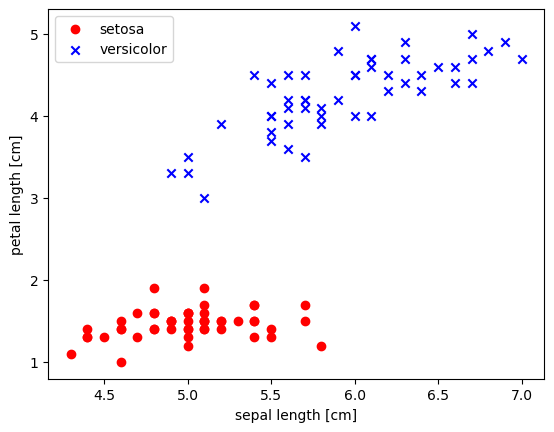

In [9]:
import matplotlib.pyplot as plt
# plot the sepal length of X as x and the petal length of X of as y in the 2D plane
# X[:50] only contains setosa
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
# X[50:100] contains versicolor
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

The preceding scatterplot shows the distribution of flower samples in the Iris dataset along the two feature axes, petal length and sepal length. In this two-dimensional feature subspace, we can see that a linear decision boundary should be sufficient to separate Setosa from Versicolor flowers. Thus, a linear classifier such as the perceptron should be able to classify the flowers in this dataset perfectly. 

Now, it's time to define write our perceptron algorithm and train it using the Iris data subset that we just extracted. Also, we will plot the misclassification error for each epoch to check whether the algorithm converged and found a decision boundary that separates the two Iris flower classes.

# Perceptron Class

Let's define the perceptron as a Python class, which allows us to initialize new Perceptron objects that can learn from data via a `fit` method, and make predictions via a separate `predict` method. 

As a convention, we append an underscore ( `_` ) to attributes that are not being created upon the initialization of the object but by calling the object's other methods, for example, `self.w_` 

In [23]:
import numpy as np
class Perceptron(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y): 
        rgen = np.random.RandomState(self.random_state)
        # self.w_[0] is just for the bias.
        # self.w_[1:] is for the real weight
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        # X.shape is just (100, 2). So it means (#rows, #column)
        print(X.shape)
        print(X.shape[1])
        print(self.w_)
        self.errors_ = []
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                # xi is a vector holding a sample of two features.
                # example: [5.1 1.4]
                # target is a vector holding the target corresponding to
                # the sample. Must be -1 or 1 in this case
                update = self.eta * (target - self.predict(xi))
                # update is the value to tweak the weights so that self.predict
                # will produce more correct output.
                # if the result from self.predict is correct,
                # update will just be 0 and this will not affect the existing
                # weights. otherwise it can be something like 0.2 or -0.2
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    def net_input(self, X):
        # the net input function actually contains the bias as well
        # which does not seem to be covered in the textbook
        return np.dot(X, self.w_[1:]) + self.w_[0] 
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

(100, 2)
2
[ 0.01624345 -0.00611756 -0.00528172]


The Perceptron class has the following parameters
* `eta` : float - Learning rate (between 0.0 and 1.0)
* `n_iter` : int - Passes over the training dataset.
* `random_state` : int - Random number generator seed for random weight initialization.

The Perceptron class has the following attributes
* `w_` : 1d-array - Weights after fitting.
* `errors_` : list - Number of misclassifications (updates) in each epoch.

You can call the `fit` function of the Perceptron class to fit training data. It has the following parameters
* `X` : {array-like}, shape = [`n_samples`, `n_features`] - Training vectors, where `n_samples` is the number of samples and `n_features` is the number of features.
* `y` : array-like, shape = [`n_samples`] - Target values.

The fit function returns the object that called it. (Useful for nested calls)

Using this perceptron implementation, we can now initialize new Perceptron
objects with a given learning rate `eta` and `n_iter`, which is the number of epochs (passes over the training set).

Via the fit method, we initialize the weights in `self.w_` to a vector $R^{m+1}$, where `m` stands for the number of dimensions (features) in the dataset, where we add 1 for the first element in this vector that represents the bias unit (the first element in this vector `self.w_[0]`).

Also notice that this vector contains small random numbers drawn from a normal distribution with standard deviation `0.01` via `rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])` , where `rgen` is a NumPy random number generator that we seeded with a user-specified random seed so that we can reproduce previous results if desired.

After the weights have been initialized, the fit method loops over all individual samples in the training set and updates the weights according to the perceptron learning rule. The class labels are predicted by the `predict` method, which is called in the fit method to predict the class label for the weight update, but predict can also be used to predict the class labels of new data after we have fitted our model. Furthermore, we also collect the number of misclassifications during each epoch in the `self.errors_` list so that we can later analyze how well our perceptron performed during the training. The `np.dot` function that is used in the **`net_input` method simply calculates the vector dot product $w^Tx$.**


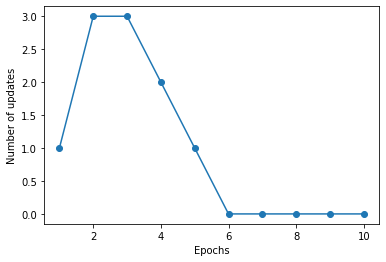

In [ ]:
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

As we can see in the preceding plot, our perceptron converged after the sixth epoch and should now be able to classify the training samples perfectly. Let us implement a small convenience function to visualize the decision boundaries for two-dimensional datasets.

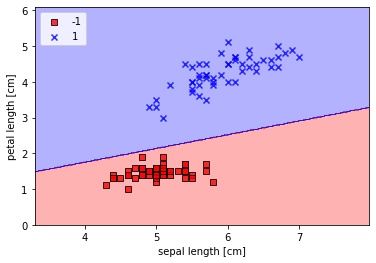

In [ ]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, 
                    c=colors[idx],  marker=markers[idx],
                    label=cl, edgecolor='black')
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

First, we define a number of `colors` and `markers` and create a colormap from the list of colors via `ListedColormap`. Then, we determine the minimum and maximum values for the two features and use those feature vectors to create a pair of grid arrays `xx1` and `xx2` via the NumPy `meshgrid` function.

Since we trained our perceptron classifier on two feature dimensions, we need to flatten the grid arrays and create a matrix that has the same number of columns as the Iris training subset so that we can use the predict method to `predict` the class labels `Z` of the corresponding grid points.

After reshaping the predicted class labels `Z` into a grid with the same dimensions as `xx1` and `xx2`, we can now draw a contour plot via Matplotlib's `contourf` function, which maps the different decision regions to different colors for each predicted class in the grid array.

As we can see in the plot, the perceptron learned a decision boundary that is able to classify all flower samples in the Iris training subset perfectly.

Although the perceptron classified the two Iris flower classes perfectly, convergence is one of the biggest problems of the perceptron. Frank Rosenblatt proved mathematically that the perceptron learning rule converges if the two classes can be separated by a linear hyperplane.

However, if classes cannot be separated perfectly by such a linear decision boundary, the weights will never stop updating unless we set a maximum number of epochs.

# Reference
Materials in this notebook are based on [Python Machine Learning](https://www.packtpub.com/data/python-machine-learning-third-edition).